## Homework 03
---
Tópicos abordados:
- Imagem Integral e Binarização Adaptativa de Imagens

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

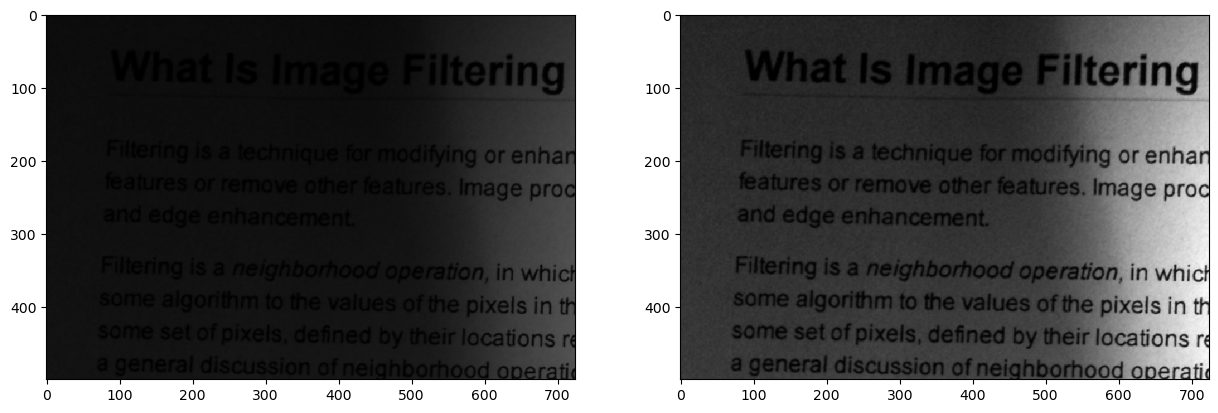

In [2]:
fname = "images/doc-roi.png"
# fname = "images/rice.png"
# fname = "images/lena.ppm"
# fname = "images/coloredChips.png"

rgb = cv.cvtColor(cv.imread( fname ), cv.COLOR_BGR2RGB)
gray = cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)

fig_imref = plt.figure( figsize=(15,10) )
plt.subplot(121)
plt.imshow(rgb)
plt.subplot(122)
plt.imshow(gray, cmap="gray")

### Questão 01) **Binarização Adaptativa**

**a)** Crie uma função que calcule a imagem integral de uma imagem em escala de cinza. Apresente as imagens integral da imagem de referência e do quadrado ponto a ponto da imagem de referência.

**b)** Crie uma função que calcula a soma dos pixels de uma área retangular qualquer usando a imagem integral. A função deve receber uma imagem integral e uma lista contendo as coordenadas de uma região retangular com o seguinte formato: `x,y,nv`, sendo `x` e `y` indicando a posição do ponto central e `nv` a quantidade de vizinhos da janela em torno de `(x,y)`, de modo que a janela tenha dimensão `nv*2+1 x nv*2+1`. Com o uso da imagem integral, implemente as funções `mean` e `variance` que calculam a média e a variância local de cada pixel e apresente os resultados para `nv=5`.

Text(0.5, 1.0, 'Image Integral Squared')

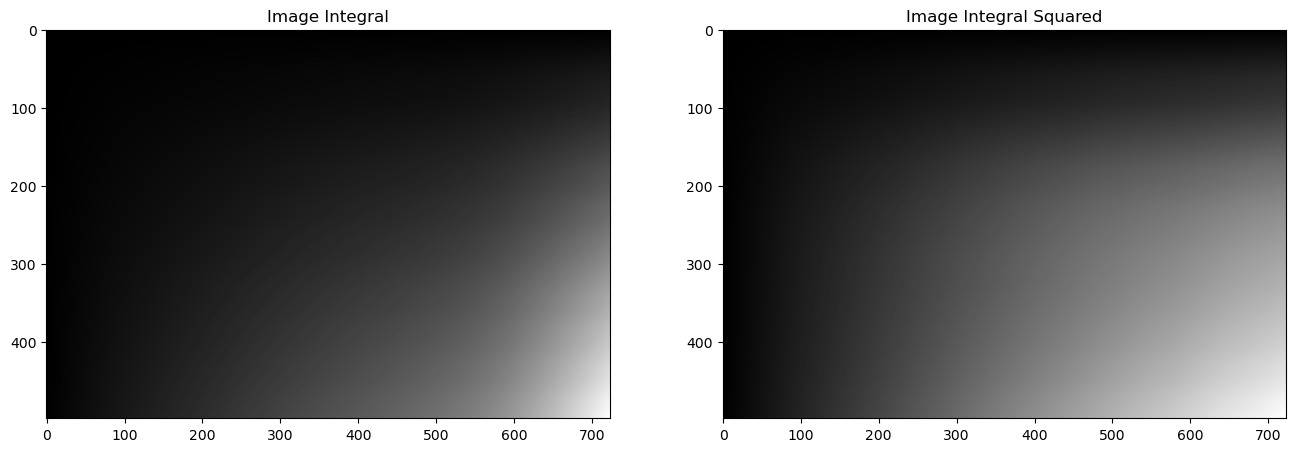

In [3]:
def image_integral(gray):
	I = np.zeros(gray.shape)
	for i in range(gray.shape[0]):
		for j in range(gray.shape[1]):
			if i == 0 and j == 0:
				I[i][j] = gray[i][j]
			elif i==0 and j != 0:
				I[i][j] = I[i,j-1]+gray[i][j]
			elif i!=0 and j == 0:
				I[i][j] = I[i-1,j]+gray[i][j]
			else:
				I[i][j] = I[i][j-1]+I[i-1][j]-I[i-1][j-1]+gray[i][j]
		pass	
	return I

I = image_integral(gray)
Isq = image_integral( np.array(gray)**2)
plt.figure( figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow( I, cmap="gray")
plt.title("Image Integral")
plt.subplot(1,2,2)
plt.imshow( Isq, cmap="gray")
plt.title("Image Integral Squared")

In [4]:
def imint_sum_area( imint, x, y, nv ) :
	'''
	Função que recebe uma imagem integral e retorna a soma dos elementos da região retangular centrada em (x,y) com nv vizinhos
	parâmetros:
			imint: imagem integral
			x: coluna do ponto de referência
			y: linha do ponto de referência
			nv: número de vizinhos do ponto central que define a janela W de observação com dimensão (nv*2+1) x (nv*2+1)
	return:
		a soma dos elementos da janela W
	'''
	a = (x-nv-1, y-nv-1)
	b = (x-nv-1, y+nv)
	c = (x+nv, y-nv-1)
	d = (x+nv, y+nv)

	if a[0] < 0 and a[1] < 0:
		soma = imint[d] #1

	elif a[0] < 0 and a[1] >= 0:
		if d[1]>=imint.shape[1]:
			soma = imint[d[0],imint.shape[1]-1]-imint[c] #3
		else:
			soma = imint[d]-imint[c] #2
	
	elif a[0] >= 0 and a[1] < 0:
		if d[0]>=imint.shape[0]:
			soma = imint[imint.shape[0]-1,d[1]]-imint[b] #6
		else:
			soma = imint[d]-imint[b] #5
	
	elif d[0] >= imint.shape[0] and d[1] >= imint.shape[1]:
		soma = imint[imint.shape[0]-1, imint.shape[1]-1]-imint[b[0],imint.shape[1]-1]-imint[imint.shape[0]-1,c[1]]+imint[a]
		#8
	elif d[0] >= imint.shape[0]:
		soma = imint[imint.shape[0]-1,d[1]]-imint[b]-imint[imint.shape[0]-1,c[1]]+imint[a]
		#7
	elif d[1] >= imint.shape[1]:
		soma = imint[d[0],imint.shape[1]-1]-imint[b[0],imint.shape[1]-1]-imint[c]+imint[a]
		#9 
	else:
		soma = imint[d]-imint[b]-imint[c]+imint[a] #4

	return soma

In [5]:
def mean( imint, nv) :
	'''
	Função que aplica o filtro da média móvel
	parâmetros:
		 imint: imagem integral
			nv: número de vizinhos que forma a janela de vizinhança
	return:
		Retorna a imagem com o valor da média da vizinhança de cada pixel
	'''
	shape = imint.shape
	mean_val = np.zeros(shape)
	for i in range(shape[0]):
		for j in range(shape[1]):

			if i-nv<0 and j-nv<0:
				mean_val[i,j] = imint_sum_area(imint, i, j, nv)/((i+nv)*(j+nv))

			elif i+nv>shape[0]-1 and j-nv<0:
				mean_val[i,j] = imint_sum_area(imint, i, j, nv)/((nv+1+(shape[0]-1-i))*(j+nv+1))

			elif i-nv<0 and j+nv>shape[1]-1:
				mean_val[i,j] = imint_sum_area(imint, i, j, nv)/((i+nv+1)*(nv+1+(shape[1]-1-j)))

			elif i-nv<0 and j-nv>=0:
				mean_val[i,j] = imint_sum_area(imint, i, j, nv)/((i+nv+1)*(2*nv+1))

			elif i-nv>=0 and j-nv<0:
				mean_val[i,j] = imint_sum_area(imint, i, j, nv)/((2*nv+1)*(j+nv+1))

			elif i+nv>shape[0]-1 and j+nv>shape[1]-1:
				mean_val[i,j] = imint_sum_area(imint, i, j, nv)/((nv+1+(shape[0]-1-i))*(nv+1+(shape[1]-1-j)))

			elif i+nv>shape[0]-1:
				mean_val[i,j] = imint_sum_area(imint, i, j, nv)/((nv+1+(shape[0]-1-i))*(2*nv+1))

			elif j+nv>shape[1]-1:
				mean_val[i,j] = imint_sum_area(imint, i, j, nv)/((2*nv+1)*(nv+1+(shape[1]-1-j)))			
				
			else:
				mean_val[i,j] = imint_sum_area(imint, i, j, nv)/((2*nv+1)**2)

	return mean_val

In [6]:
def variance( imint, imintsq, nv) :
	'''
	Função que aplica o filtro da variância móvel
	parâmetros:
		 	imint: imagem integral
		  imintsq: imagem integral do quadrado dos pixels da imagem original
			   nv: número de vizinhos que forma a janela de vizinhança
	return:
		Retorna a imagem com o valor da variância da vizinhança de cada pixel
	'''
	return mean(imintsq, nv) - mean(imint, nv)**2


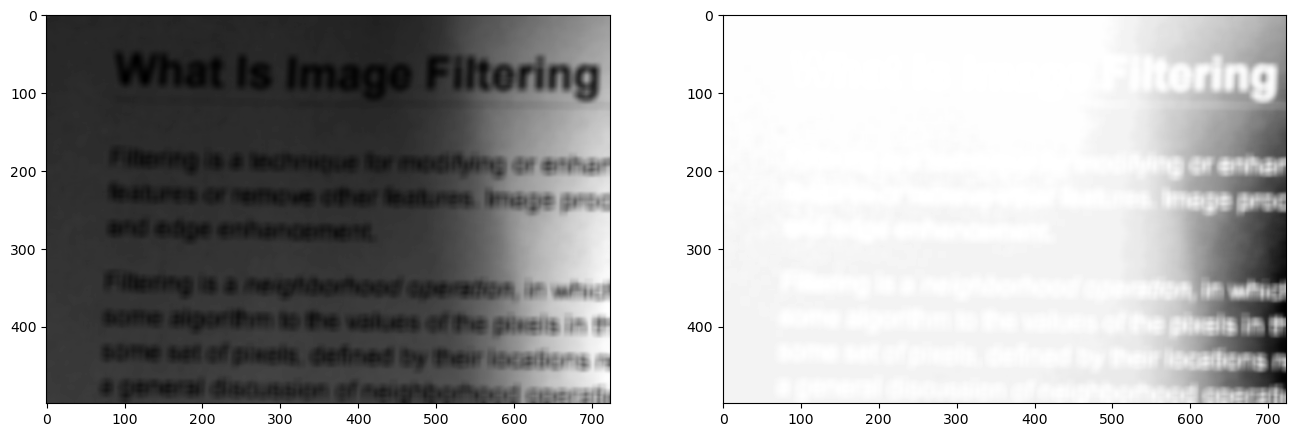

In [7]:
U = mean(I,5)
V = variance(I, Isq,5)
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(U, cmap='gray')
plt.subplot(122)
plt.imshow(V, cmap='gray')

**c)** Implemente a limiarização adaptativa de Niblack usando imagem integral. O algoritmo de Niblack define um limiar local com base na média e na variância local do pixel observado. Seja $th(x,y,k)$ o limiar adaptativo do ponto $(x,y)$ definido como $th(x,y,k) = \mu +k\sigma$, onde $\mu$ é a média local do ponto, $\sigma$ o desvio padrão e $k$ um fator de ponderação do desvio padrão. Apresente a imagem binarizada para $nv=5$ e $k=0.5$.

In [8]:
def adaptive_threshold( img, imint, imintsq, nv, k ) :
	'''
	Binarização Adaptativa de Niblack
	Parâmetros:
		img: image original
		imint: imagem integral
		imintsq: imagem integral do quadrado dos pixels
		nv: quantidade de vizinhos
		k: peso do desvio padrão
	return:
		Uma imagem Binária [0,1]
	'''
	U = mean(imint, nv)
	V = variance(imint, imintsq, nv)
	result = np.where(img < (U+k*np.sqrt(np.abs(V))), 0, 1)
	return result

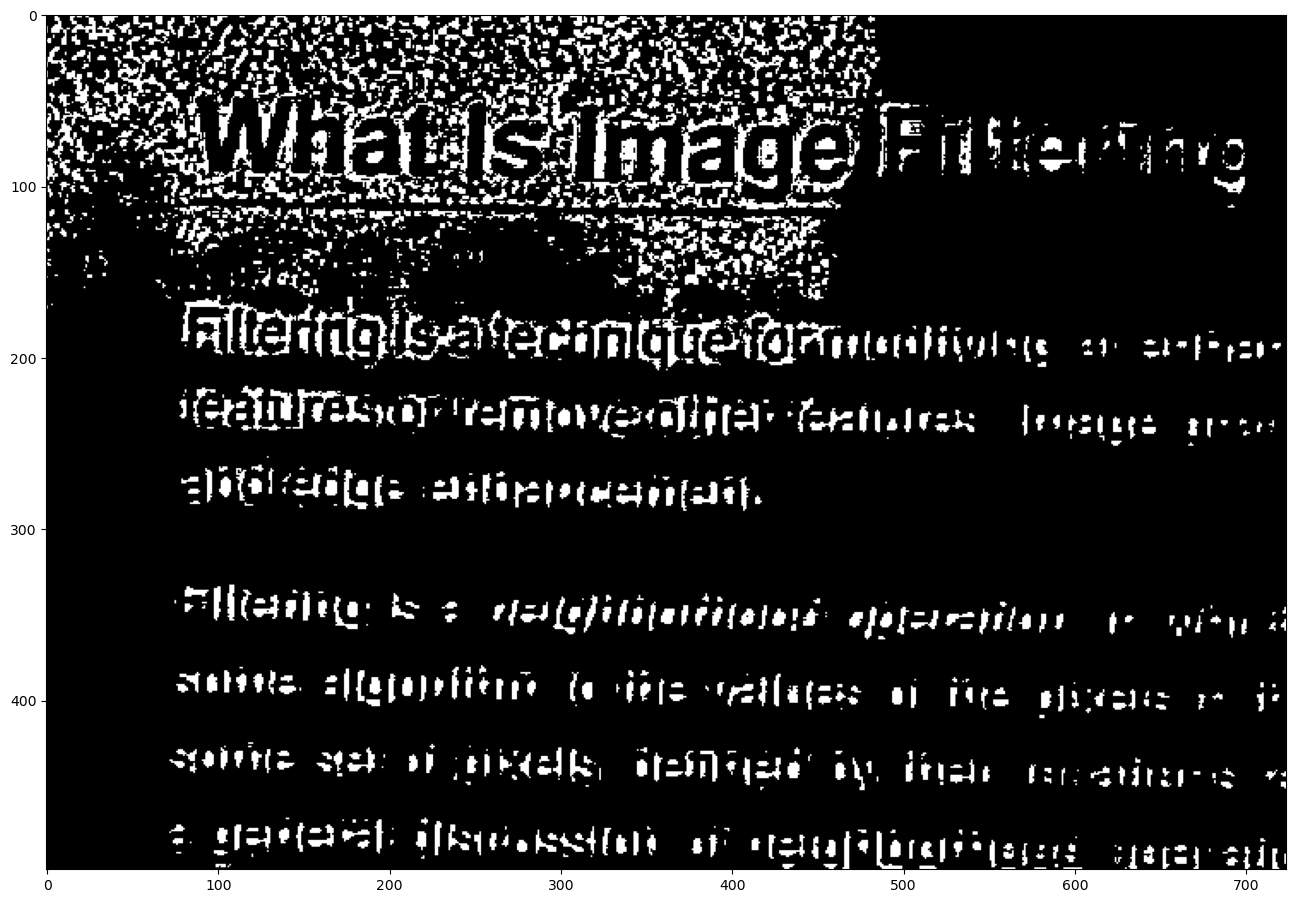

In [9]:
imint = image_integral(gray)
imintsq = image_integral(np.array(gray)**2)

BW = adaptive_threshold( gray, imint, imintsq, 5, 0.5)
plt.figure( figsize=(16,16))
plt.imshow( BW, cmap='gray' )


**d)** Explique, usando exemplos, o efeito causado pela escolha de valores diferentes para $k$, considerando valores positivos e também negativos.

Ao modificar-se o valor de k, troca-se o valor limiar ao redor da média calculada (nesse caso para 5 vizinhos) com relação ao desvio padrão. Ao comparar a imagem original com a média calculada, quanto maior o valor de k, positivo ou negativo, mais a imagem tenderá a ser escura ou clara, respectivamente.

Text(0.5, 0.9, 'Comparando os valores de vizinhança e variando o valor de k entre -0.5 e 0.5')

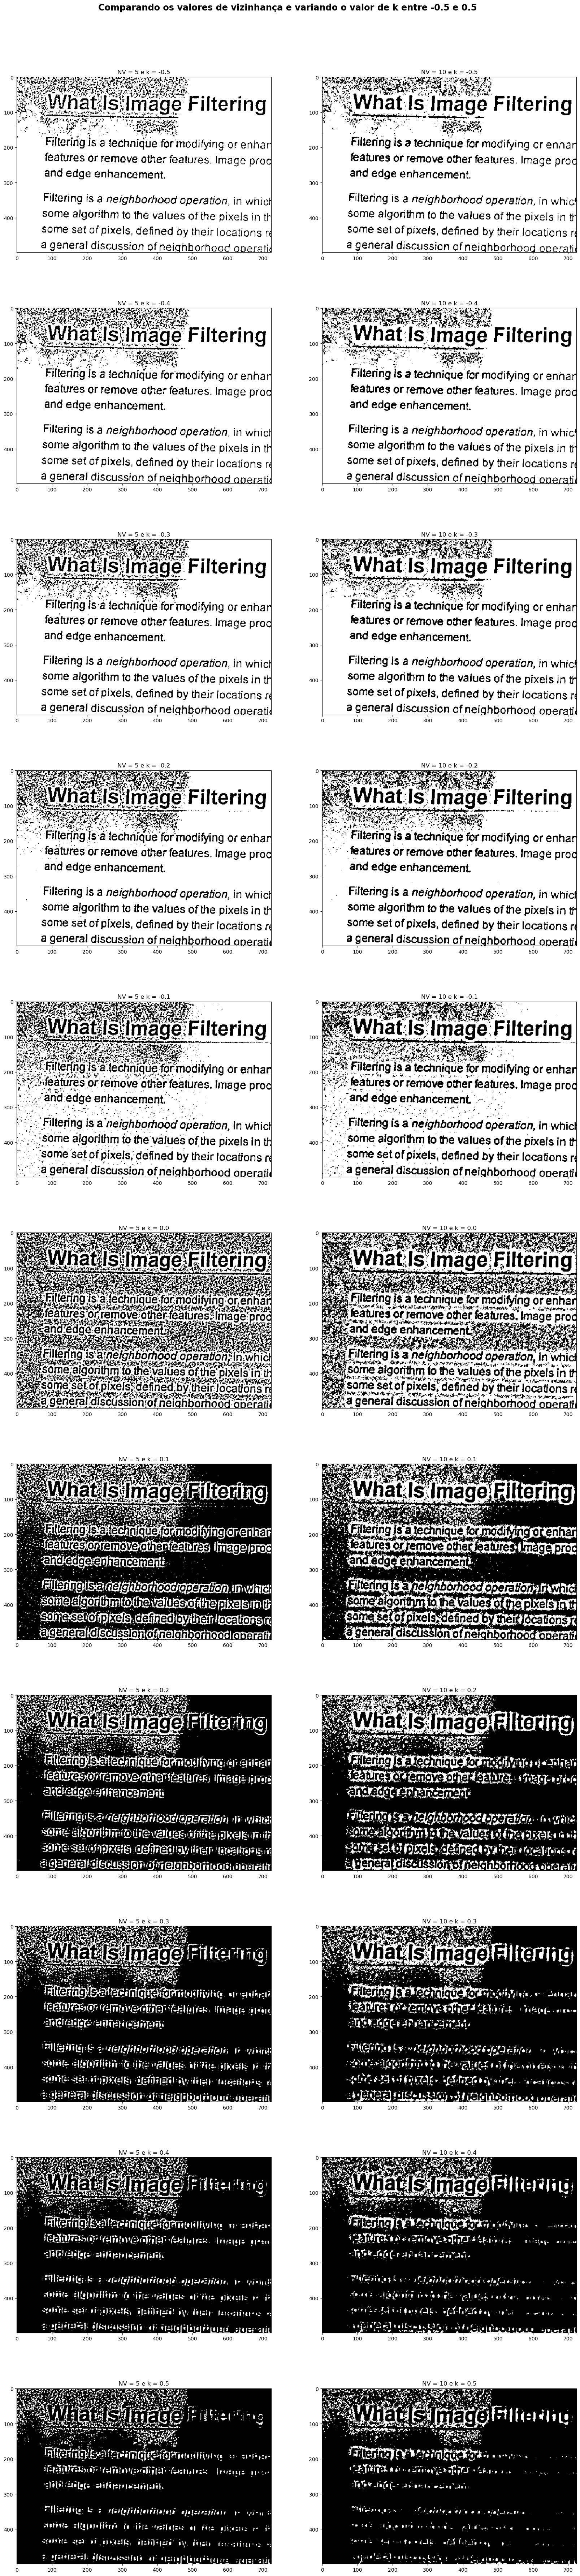

In [15]:
k = np.linspace(-0.5, 0.5, 11)


fig, ax = plt.subplots(np.ceil(len(k)).astype('int'), 2, figsize=(20,90))

i=0
for val in k:
    BW_5 = adaptive_threshold( gray, imint, imintsq, 5, val)
    BW_10 = adaptive_threshold( gray, imint, imintsq, 10, val)
    ax[int(i),0].imshow( BW_5, cmap='gray')
    ax[int(i),0].set_title(f'NV = 5 e k = {val:.1f}')
    ax[int(i),1].imshow( BW_10, cmap='gray')
    ax[int(i),1].set_title(f'NV = 10 e k = {val:.1f}')
    i+=1

plt.suptitle('Comparando os valores de vizinhança e variando o valor de k entre -0.5 e 0.5', size='xx-large', weight='bold', y=0.9)